# 特征构建：生成新特征

本章内容：

- 检查数据集
- 填充分类特征
- 编码分类变量
- 扩展数值特征
- 针对文本的特征构建

## 4.1 检查数据集

为了展示不同的数据等级和类型，首先创建一个自己的数据集：

In [3]:
import pandas as pd

X = pd.DataFrame({
    '城市': ['太原', None, '上海', '太原', '深圳', '西安'],
    '是否宜居': ['是', '否',  '否', None, '否', '是'],
    '欢迎程度': ['有点喜欢', '喜欢', '有点喜欢', '喜欢', '有点喜欢', '不喜欢'],
    '年人均收入（万元）': [6.25, None, 4.86, 8.24, 5.20, 7.20]
})
X

,城市,是否宜居,欢迎程度,年人均收入（万元）
0,太原,是,有点喜欢,6.25
1,None,否,喜欢,NaN
2,上海,否,有点喜欢,4.86
3,太原,None,喜欢,8.24
4,深圳,否,有点喜欢,5.20
5,西安,是,不喜欢,7.20


观察每一列，并识别每列的类型和等级：

- 城市：此列是分类数据，也是定类等级
- 是否省会：此列是二元分类数据（是/否），定类等级
- 评价：此列是顺序数据，定序等级
- 年人均收入（万元）：此列是数值，定比等级

## 4.2 填充分类特征

对要处理的数据有了一定的理解后，现在可以看看缺失值：

In [9]:
X.isnull().sum()

城市           1
是否宜居         1
欢迎程度         0
年人均收入（万元）    1
dtype: int64

可见，有3列存在缺失值。接下来当然要填充这些值。

上一章使用了scikit-learn中Impute模块的估算器（Imputer）填充缺失值，但主要用于填充数值数据。虽然这些Imputer有一个most_frequent方法可以用在**定性数据**上，但是只能处理**整型的分类数据**。通常不这样做，因为这种转换会改变对分类数据的解释方式。因此需要编写自己的转换器填充每列的缺失值。

本章将创建自定义转换器，这些转换器对转换数据帮助很大，而且可以实现Pandas和scikit-learn不支持的操作。

先从定性列“城市”开始。对于数值数据，可以通过计算均值的方法填充缺失值；而对于分类数据，也有类似的处理方法：计算出最常见的类别用于填充。为此，需要找出"城市"列中最常见的类别：

In [10]:
X['城市'].value_counts().index[0]

'太原'

使用出现最频繁的类别填充缺失值：

In [11]:
X['城市'].fillna(X['城市'].value_counts().index[0])

0    太原
1    太原
2    上海
3    太原
4    深圳
5    西安
Name: 城市, dtype: object

现在“城市”列没有缺失值。对于“是否宜居”列，这里不再使用同样的方法，而是构建一个自定义填充器，用来处理分类数据的填充。

### 自定义填充器

在写代码之前，快速回顾一下机器学习流水线：

- 用流水线按顺序应用转换和最终的预测器
- 流水线的中间步骤只能是转换，这意味着它们必须实现fit和transform方法
- 最终的预测器只需要实现fit方法

流水线的目的是将几个可以交叉验证的步骤组装在一起，并设置不同的参数。在为每个需要填充的列构建好自定义转换器后，就可以把它们传入流水线，一口气转换好数据。

下面开始编写第一个自定义分类填充器：

In [13]:
from sklearn.base import TransformerMixin

class CustomCategoryImputer(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
    def transform(self, df):
        X = df.copy()
        for col in self.cols:
            X[col].fillna(X[col].value_counts().index[0], inplace=True)
        return X
    
    def fit(self, *_):
        return self

有了自定义分类填充器，先用其在“城市”和“是否宜居”两列上适用一下：

In [21]:
cci = CustomCategoryImputer(cols=['城市', '是否宜居'])
cci.fit_transform(X)

,城市,是否宜居,欢迎程度,年人均收入（万元）
0,太原,是,有点喜欢,6.25
1,太原,否,喜欢,NaN
2,上海,否,有点喜欢,4.86
3,太原,否,喜欢,8.24
4,深圳,否,有点喜欢,5.20
5,西安,是,不喜欢,7.20


现在“城市”和“是否宜居”列都没有缺失值。还差定量列“年人均收入”还有缺失值。如法炮制，再编写一个基于列名的自定义定量填充器：

In [18]:
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin

class CustomquantitativeImputer(TransformerMixin):
    def __init__(self, cols=None, strategy='mean'):
        self.cols = cols
        self.strategy = strategy
        
    def transform(self, df):
        X = df.copy()
        imputer = SimpleImputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = imputer.fit_transform(X[[col]])
        return X
    
    def fit(self, *_):
        return self


测试一下：

In [22]:
cqi = CustomquantitativeImputer(cols=['年人均收入（万元）'])
cqi.fit_transform(X)

,城市,是否宜居,欢迎程度,年人均收入（万元）
0,太原,是,有点喜欢,6.25
1,太原,否,喜欢,6.35
2,上海,否,有点喜欢,4.86
3,太原,否,喜欢,8.24
4,深圳,否,有点喜欢,5.20
5,西安,是,不喜欢,7.20


现在，没有缺失值了，定性列和定量列都进行了合理的填充。那么，如何让机器学习算法利用分类数据呢？

## 4.3 编码分类变量

为了让机器学习算法利用分类数据，需要**将分类数据转换为数值数据**，即**编码**。因为几乎所有机器学习算法，无论是线性回归还是利用欧几里得距离的KNN算法，需要的输入特征都必须是数值.

将分类数据转换为数值数据（编码）的方法跟分类变量的等级有关，有以下几种方法：

### 定类等级数据的编码

对于定类等级，主要方法是将分类数据转换为虚拟（哑）变量（dummy variable）,也称为One-hot编码（独热编码），有两种选择：

- 用Pandas自动对分类变量进行编码
- 创建自定义虚拟变量编码器，并用于流水线

什么是虚拟变量？ 虚拟变量的取值是1或0，代表是否是某个类别。虚拟变量是定性数据的代理，或者是分类的数值型替代。

回到数据集中，用第一种选择将分类数据编码成虚拟变量：

In [24]:
pd.get_dummies(X, columns = ['城市', '是否宜居'], prefix_sep='_')

,欢迎程度,年人均收入（万元）,城市_上海,城市_太原,城市_深圳,城市_西安,是否宜居_否,是否宜居_是
0,有点喜欢,6.25,0,1,0,0,0,1
1,喜欢,NaN,0,1,0,0,1,0
2,有点喜欢,4.86,1,0,0,0,1,0
3,喜欢,8.24,0,1,0,0,1,0
4,有点喜欢,5.20,0,0,1,0,1,0
5,不喜欢,7.20,0,0,0,1,0,1


这种选择要求必须指定应用虚拟化的列，因为Pandas也会编码定序等级的列，这就没有意义了。

另一个选择是创建一个自定义虚拟化器，从而在流水线中一口气转换整个数据集：

In [26]:
class CustomDummifier(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cols)
    
    def fit(self, *_):
        return self

我们自定义的虚拟编码器模仿了scikit-learn的OneHotEncoding，但可以在整个DateFrame上运行。测试一下：

In [27]:
cd = CustomDummifier(cols=['是否宜居','城市'])
cd.fit_transform(X)

,欢迎程度,年人均收入（万元）,是否宜居_否,是否宜居_是,城市_上海,城市_太原,城市_深圳,城市_西安
0,有点喜欢,6.25,0,1,0,1,0,0
1,喜欢,NaN,1,0,0,1,0,0
2,有点喜欢,4.86,1,0,1,0,0,0
3,喜欢,8.24,1,0,0,1,0,0
4,有点喜欢,5.20,1,0,0,0,1,0
5,不喜欢,7.20,0,1,0,0,0,1


### 定序等级数据的编码

在定序等级，由于数据的顺序有含义，使用虚拟变量是没有意义的。为了保持顺序，我们使用标签编码器。

标签编码器是指，顺序数据的每个标签都会有一个相关数值。这意味着“欢迎程度”列的值（不喜欢、 有点喜欢和喜欢）会用0、1、2来表示。

最简单的编码方法如下：

In [28]:
ordering = ['不喜欢', '有点喜欢', '喜欢']
X['欢迎程度'].map(lambda x: ordering.index(x))

0    1
1    2
2    1
3    2
4    1
5    0
Name: 欢迎程度, dtype: int64

注意，这里没有使用scikit-learn的LabelEncoder，因为LabelEncoder不能像上述代码那样按照我们期望的顺序进行编码（0表示“不喜欢”，1表示“有点喜欢”，2表示“喜欢”）。LabelEncoder是用字符串排序的方式确定编码，这不一定符合实际需求。

为了能将上述编码方法用于流水线，把上述代码封装为自定义标签编码器：

In [32]:
class CustomEncoder(TransformerMixin):
    def __init__(self, col, ordering=None):
        self.ordering = ordering
        self.col = col
    
    def transform(self, df):
        X = df.copy()
        X[self.col] = X[self.col].map(lambda x: self.ordering.index(x))
        return X
    
    def fit(self, *_):
        return self


测试一下：

In [33]:
ce = CustomEncoder(col='欢迎程度', ordering=['不喜欢','有点喜欢','喜欢'])
ce.fit_transform(X)

,城市,是否宜居,欢迎程度,年人均收入（万元）
0,太原,是,1,6.25
1,太原,否,2,NaN
2,上海,否,1,4.86
3,太原,否,2,8.24
4,深圳,否,1,5.20
5,西安,是,0,7.20


OK，”欢迎程度“列编码成功。到这里，我们已经转换了如下这些列：

- "城市“和”是否宜居“：虚拟变量编码
- ”欢迎程度“：标签编码

### 将连续值分箱

如果数值数据是连续的，那么将其转换为分类变量可能是有意义的。比如年龄分段（幼年、童年、少年、青年、中年、老年等）。

Pandas有一个有用的函数叫作cut，可以将数据分箱（binning），亦称为分桶（bucketing），即数据的范围：

In [34]:
pd.cut(X['年人均收入（万元）'], bins=3)

0    (5.987, 7.113]
1               NaN
2    (4.857, 5.987]
3     (7.113, 8.24]
4    (4.857, 5.987]
5     (7.113, 8.24]
Name: 年人均收入（万元）, dtype: category
Categories (3, interval[float64]): [(4.857, 5.987] < (5.987, 7.113] < (7.113, 8.24]]

仿照之前的转换器结构，可以为流水线定义自己的CustomCutter:

In [36]:
class CustomCutter(TransformerMixin):
    def __init__(self, col, bins, labels=False):
        self.labels = labels
        self.bins = bins
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = pd.cut(X[self.col], bins=self.bins, labels=self.labels)
        return X
    
    def fit(self, *_):
        return self

测试一下：

In [37]:
cc = CustomCutter(col='年人均收入（万元）', bins=3)
cc.fit_transform(X)

,城市,是否宜居,欢迎程度,年人均收入（万元）
0,太原,是,有点喜欢,1.0
1,太原,否,喜欢,NaN
2,上海,否,有点喜欢,0.0
3,太原,否,喜欢,2.0
4,深圳,否,有点喜欢,0.0
5,西安,是,不喜欢,2.0


### 创建流水线

我们对数据集里的列进行了以下转换：

- "城市“和”是否宜居“：虚拟变量编码
- “欢迎程度”：标签编码
- ”年人均收入（万元）“：分箱

把自定义转换器按以下的顺序组装为流水线：

1. 用imputer填充缺失值
2. 用虚拟变量填充分类列（“城市”和“是否宜居”）
3. 对“欢迎程度”进行标签编码
4. 将“年人均收入（万元）“分箱

In [50]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    ('imputer_c', cci), # 填充缺失的定性值
    ('imputer_q', cqi), # 填充缺失的定量值
    ('dummify', cd),    # 定类虚拟编码
    ('encode', ce),     # 定序标签编码
    ('cut', cc)         # 定量分箱
])

# 查看进入流水线前的数据
X

,城市,是否宜居,欢迎程度,年人均收入（万元）
0,太原,是,有点喜欢,6.25
1,None,否,喜欢,NaN
2,上海,否,有点喜欢,4.86
3,太原,None,喜欢,8.24
4,深圳,否,有点喜欢,5.20
5,西安,是,不喜欢,7.20


In [48]:
# 拟合流水线
pipe.fit(X)

Pipeline(memory=None,
         steps=[('imputer_c',
                 <__main__.CustomCategoryImputer object at 0x7f8c050f3e50>),
                ('imputer_q',
                 <__main__.CustomquantitativeImputer object at 0x7f8c02877e50>),
                ('dummify',
                 <__main__.CustomDummifier object at 0x7f8c02834950>),
                ('encode', <__main__.CustomEncoder object at 0x7f8c0284b710>),
                ('cut', <__main__.CustomCutter object at 0x7f8c0284bed0>)],
         verbose=False)

In [49]:
# 转换DataFrame
pipe.transform(X)

,欢迎程度,年人均收入（万元）,是否宜居_否,是否宜居_是,城市_上海,城市_太原,城市_深圳,城市_西安
0,1,1,0,1,0,1,0,0
1,2,1,1,0,0,1,0,0
2,1,0,1,0,1,0,0,0
3,2,2,1,0,0,1,0,0
4,1,0,1,0,0,0,1,0
5,0,2,0,1,0,0,0,1


## 4.4 扩展数值特征

可以从数值特征中创建扩展特征。在深入研究前，先介绍一个新的数据集。

### 根据胸部加速计识别动作的数据集

此数据集来自佩戴在胸部的加速计，它收集了15名参与者的7种动作。采样频率是52Hz，加度计数据未校准。

数据来源：[UCI机器学习库](https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer)

数据集按参与者划分，包含以下属性：

- 序号
- x轴加速度
- y轴加速度
- z轴加速度
- 标签

标签是数字，每个数字代表一种动作（activity），如下所示：

- 1: 在电脑前工作
- 2: 站立、走路和上下楼梯
- 3: 站立
- 4: 走路
- 5: 上下楼梯
- 6: 与人边走边聊
- 7: 站立着讲话

开始探索数据：

In [52]:
df = pd.read_csv('sample_data/activity_recognition/1.csv', header=None)
df.columns = ['index', 'x', 'y', 'z', 'activity']
df.head()

,index,x,y,z,activity
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1


此数据集的目的是训练模型，以便根据智能手机等设备上加速度计的x、y、z读数识别用户的当前动作，即预测activity列。

首先确定要击败的空准确率（可能结果的猜中率）：

In [53]:
df['activity'].value_counts(normalize=True)

7    0.515369
1    0.207242
4    0.165291
3    0.068793
5    0.019637
6    0.017951
2    0.005711
0    0.000006
Name: activity, dtype: float64

空准确率是51.54%，意外着如果我们猜7（站着讲话），正确率就超过一半了。现在开始进行机器学习，一步步建立模型：

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

这里还是用scikit-learn的KNN分类模型和网格搜索模块，该模块自动找到最适合数据的KNN参数组合，以达到最佳的**交叉验证准确率**。

然后，为预测模型创建一个特征矩阵（X）和一个响应变量（y）：

In [56]:
X = df[['x', 'y', 'z']]
y = df['activity']
X.head(),y.head()

(      x     y     z
 0  1502  2215  2153
 1  1667  2072  2047
 2  1611  1957  1906
 3  1601  1939  1831
 4  1643  1965  1879,
 0    1
 1    1
 2    1
 3    1
 4    1
 Name: activity, dtype: int64)

引入网格搜索所需的参数和实例:

In [61]:
# KNN模型参数
knn_params = {'n_neighbors': [3, 4, 5, 6]}

实例化一个KNN模型和一个网格搜索模块，并且用特征矩阵和响应变量拟合：

In [62]:
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, knn_params)
grid.fit(X, y)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [3, 4, 5, 6]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [63]:
grid.best_score_, grid.best_params_

(0.7408140649873495, {'n_neighbors': 5})

使用5个邻居作为参数时，KNN模型准确率达到了74.08%，比51.54%的空准确率高很多。也许还有别的办法可以进一步提高准确率。

### 多项式特征

在处理数值数据、创建更多特征时，一个关键方法是使用scikit-learn的PolynomialFeatures类。这个类会生成一个新的特征矩阵，里面是原始数据各个特征的多项式组合，阶数小于或等于指定的阶数。意思是，如果输入是二维的，例如[a, b]，那么二阶的多项式特征就是[1, a, b, a^2, ab, b^2]

#### 1.参数

在实例化多项式特征时，需要了解3个参数：

- degree：多项式特征的阶数，默认值是2
- interaction_only：布尔值：如果为真，表示只生成互相影响/交互的特征，也就是不同阶数特征的乘积。默认为false
- include_bias：布尔值：如果为真（默认），会生成一列阶数为0的偏差列，也就是说列中全是数字1

导入这个多项式特征类，并设置参数来实例化。首先看看将interaction_only设成False时的数据：

In [79]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, 
                          include_bias=False, 
                          interaction_only=False)

X_poly = poly.fit_transform(X)
print(X.shape, '-->', X_poly.shape)

(162501, 3) --> (162501, 9)


In [80]:
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
0,1502.0,2215.0,2153.0,2256004.0,3326930.0,3233806.0,4906225.0,4768895.0,4635409.0
1,1667.0,2072.0,2047.0,2778889.0,3454024.0,3412349.0,4293184.0,4241384.0,4190209.0
2,1611.0,1957.0,1906.0,2595321.0,3152727.0,3070566.0,3829849.0,3730042.0,3632836.0
3,1601.0,1939.0,1831.0,2563201.0,3104339.0,2931431.0,3759721.0,3550309.0,3352561.0
4,1643.0,1965.0,1879.0,2699449.0,3228495.0,3087197.0,3861225.0,3692235.0,3530641.0


### 2. 探索性数据分析

因为多项式特征的目的是更好地理解原始数据的特征交互情况，所以最好的可视化办法是关联热图：

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr())
plt.show()

NameError: name 'pd' is not defined

interaction_only参数是False,将其设成True试试：

In [82]:
poly = PolynomialFeatures(degree=2, 
                          include_bias=False, 
                          interaction_only=True)
X_poly = poly.fit_transform(X)
print(X.shape, '-->', X_poly.shape)

(162501, 3) --> (162501, 6)


In [83]:
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,x0,x1,x2,x0 x1,x0 x2,x1 x2
0,1502.0,2215.0,2153.0,3326930.0,3233806.0,4768895.0
1,1667.0,2072.0,2047.0,3454024.0,3412349.0,4241384.0
2,1611.0,1957.0,1906.0,3152727.0,3070566.0,3730042.0
3,1601.0,1939.0,1831.0,3104339.0,2931431.0,3550309.0
4,1643.0,1965.0,1879.0,3228495.0,3087197.0,3692235.0


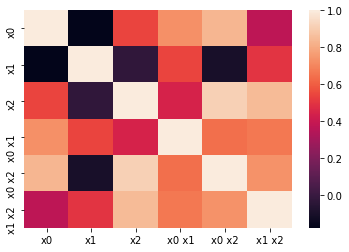

In [84]:
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr())
plt.show()

可以用新的多项式特征对KNN模型进行网格搜索，这也可以在流水线中进行:

In [85]:
from sklearn.pipeline import Pipeline

# 设置流水线参数：
pipe_params = {
    'poly_features__degree': [1, 2, 3],
    'poly_features__interaction_only': [True, False],
    'classify__n_neighbors': [3, 4, 5, 6]
}

# 实例化流水线
pipe = Pipeline([
    ('poly_features', poly),
    ('classify', knn)
])

# 设置网格搜索，打印最佳准确率和学习到的参数
grid = GridSearchCV(pipe, pipe_params)
grid.fit(X, y)

grid.best_score_, grid.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


(0.7408140649873495,
 {'classify__n_neighbors': 5,
  'poly_features__degree': 1,
  'poly_features__interaction_only': True})

准确率仍然是74.08%，比之前不用多项式扩展的准确率没有变化，但训练的时间增加了10倍多。

## 4.5 针对文本的特征构建（选讲）

到目前为止，我们一直在处理分类数据和数值数据。虽然分类数据是字符串，但是里面的文本仅仅是某个类别。我们现在进一步探索更长的文本数据。这种**文本数据**比单个类别的文本复杂得多，因为长文本包括一系列类别，或称为**词项（token）**。

考虑一下商户点评：用户在平台上撰写对餐厅和商家的评论，分享对自己体验的看法。这些评论都是文本格式的，包含可用于机器学习的大量有用信息，例如预测最应该去的餐厅。

在当今世界中，我们沟通方式的很大一部分还是基于书面文本，无论使用的是聊天服务、社会媒体，还是电子邮件。通过建模，我们可以从中获得海量信息，例如用微博数据进行情绪分析。

这个过程被称为**自然语言处理**（NLP，naturallanguage processing）。这个领域主要涉及计算机与人类的交流，特别是对计算机进行编程，以处理自然语言。

所有的机器学习模型都需要数值输入。因此处理文本时需要有创造性，有策略地思考如何将文本数据转换为数值特征。下面就介绍文本到数值的转换方法：

### 词袋法

scikit-learn的feature_extraction模块能以机器学习算法支持的方法提取数据的特征，包括文本数据（也称为语料库Corpus，尤其指文本内容或文档的集合）。

将语料库转换为数值表示（也就是向量化）的常见方法是**词袋（bag of words）法**，其背后的基本思想是：通过单词的出现频率来描述文档，完全忽略单词在文档中的位置。

词袋，顾名思义，用一个袋子表示文本，不考虑语法和词序，并将这个袋子视作一个集合，其中重复度高的单词更重要。 创建词袋的3个步骤是：

- 分词（tokenizing）：用空白和标点将单词分开，将其变为词项。每个可能出现的词项都有一个整数ID
- 计数（counting）：简单地计算文档中词项的出现次数
- 归一化（normalizing）：将词项在大多数文档中的重要性按逆序排列

### CountVectorizer

CountVectorizer是将文本数据转换为其向量表示的最常用办法。和虚拟变量类似，CountVectorizer将文本列转换为矩阵，其中的列是词项，单元值是每个文档中每个词项的出现次数。这个矩阵叫文档-词矩阵（document-term matrix），因为每行代表一个文档（在本例中是一条推文），每列代表一个词（一个单词）。

下面用一个新的数据集展示CountVectorizer的工作原理。[Twitter情感分析数据集](https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech?select=train.csv)包括1578627条分类后的推文，每行标记为1或0：前者代表正面情绪，后者代表负面情绪。

In [86]:
!ls sample_data

2013-sfo-customer-survey.csv
activity_recognition
DataDictionary_2013-SFO-Customer-Survey.pdf
GlobalLandTemperaturesByCountry.csv
pima-indians-diabetes.csv
salary-ranges-by-job-classification.csv
twitter-sentiment-analysis-train.csv


In [4]:
tweets = pd.read_csv('sample_data/twitter-sentiment-analysis-train.csv', encoding='latin1')
tweets.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


本例只关注Sentiment和SentimentText列，所以删除ItemID列：

In [5]:
del tweets['ItemID']
tweets.head()

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


下面导入CountVectorizer，更好地理解这些文本：

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

X = tweets['SentimentText']
y = tweets['Sentiment']

cv = CountVectorizer()
_ = cv.fit_transform(X)
print(X.shape, '-->', _.shape)

(99989,) --> (99989, 105849)


#### CountVectorizer的参数:

- stop_words: 停用词，即从词项中删除，不会表示为特征的词
- min_df: 最少词频阈值，通过忽略在文档中出现频率低于阈值的词，减少特征的数量
- max_df: 最大词频阈值，词频超过该阈值的词被忽略，不会表示为特征
- ngram_range: 短语中的单词数量范围，这个参数接收一个元组，表示n值的范围
- analyzer： 分析器，判断特征是单词还是短语。默认是单词

下面依次查看一下这些参数对特征数量的影响：

In [7]:
# 设置停用词
cv = CountVectorizer(stop_words='english')
_ = cv.fit_transform(X)
print(X.shape, '-->', _.shape)

(99989,) --> (99989, 105545)


In [8]:
# 设置最少词频阈值
cv = CountVectorizer(min_df=.05)
_ = cv.fit_transform(X)
print(X.shape, '-->', _.shape)

(99989,) --> (99989, 31)


In [9]:
# 设置最少词频阈值
cv = CountVectorizer(max_df=.2)
_ = cv.fit_transform(X)
print(X.shape, '-->', _.shape)

(99989,) --> (99989, 105846)


In [ ]:
# 设置最少词频阈值
cv = CountVectorizer(ngram_range=(1, 2))
_ = cv.fit_transform(X)
print(X.shape, '-->', _.shape)

In [11]:
# 设置分析器
cv = CountVectorizer(analyzer='word')
_ = cv.fit_transform(X)
print(X.shape, '-->', _.shape)

(99989,) --> (99989, 105849)


可以创建自定义分析器。理论上说，单词是由词根或词干构建而来的，所以可以据此写一个自己的分析器。

词干提取（stemming）是一种常见的自然语言处理方法，可以将词汇中的词干提取出来，也就是把单词转换为其词根，从而缩小词汇量。

NLTK是一个自然语言工具包，里面有几个可以处理文本数据的包，stemmer就是其中之一。下面了解一下其用法：

In [13]:
# 安装nltk包
!pip install nltk

     |████████████████████████████████| 1.4 MB 38 kB/s eta 0:00:01
     |████████████████████████████████| 660 kB 48 kB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434675 sha256=7761fa6ecc502e3463f176782c2d79abe58246bb0dbe3cb2932ab338d8406f74
  Stored in directory: /home/jovyan/.cache/pip/wheels/45/6c/46/a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266
Successfully built nltk


In [16]:
# 导入nltk中的stemmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
stemmer.stem('interesting'),stemmer.stem('illness')

('interest', 'ill')

单词变成了相应的词根。现在定义一个函数，将单词转换为词根：

In [17]:
def word_tokenize(text):
    words = text.split(' ') # 按空格分词
    return [stemmer.stem(word) for word in words]

测试一下：

In [18]:
word_tokenize("what are you doing")

['what', 'are', 'you', 'do']

将此分词器作为CountVectorizer的分析器参数：

In [21]:
cv = CountVectorizer(stop_words='english', analyzer=word_tokenize)
_ = cv.fit_transform(X)
print(X.shape, '-->', _.shape)

(99989,) --> (99989, 154397)


### TF-IDF向量化器

TF-IDF向量化器由两部分组成：**表示词频的TF**部分，以及**表示逆文档频率的IDF**部分。TF-IDF是一个用于信息检索和聚类的词加权方法。

对于语料库中的文档，TF-IDF会给出其中单词的权重，表示重要性。相关概念介绍如下：

- **TF（term frequency，词频**）：衡量**词在文档中出现的频率**。由于文档的长度不同，词在长文中的出现次数有可能比在短文中出现的次数多得多。因此，一般会对词频进行归一化，用其除以文档长度或文档的总词数。
- **IDF（inverse document frequency，逆文档频率）**：衡量**词的重要性**。在计算词频时，我们认为所有的词都同等重要。但是某些词（如is、of和that）有可能出现很多次，但这些词并不重要。因此，我们需要**减少常见词的权重，加大稀有词的权重**

TfidfVectorizer和CountVectorizer类似，都从词项构造了特征，但是TfidfVectorizer进一步将词项计数按照在语料库中出现的频率进行了归一化。下面看一个例子：

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

cv = CountVectorizer()
_ = cv.fit_transform(X)

print(X.shape, '-->', _.shape, 'Mean:', _[0,:].mean())

(99989,) --> (99989, 105849) Mean: 6.613194267305311e-05


In [23]:
tv = TfidfVectorizer()
_ = tv.fit_transform(X)

print(X.shape, '-->', _.shape, 'Mean:', _[0,:].mean())

(99989,) --> (99989, 105849) Mean: 2.1863060975751192e-05


可见，两个**向量化器**输出的行列数相同，但是里面的值不同。这是因为TfidfVectorizer和CountVectorizer把文本数据转换为定量数据时，填充单元值的方法不同。

### 在机器学习流水线中使用文本

向量化器的最终目标是让机器学习流水线**理解文本数据**。CountVectorizer和TfidfVectorizer与其他转换器一样，可以装配到机器学习流水线中。由于列数很多（十几万），这里更高效的分类器——朴素贝叶斯（naive Bayes）模型：

In [24]:
# 特征数多时更快
from sklearn.naive_bayes import MultinomialNB

在开始构建流水线之前，看一下响应列的空准确率（0是负面情绪，1是正面情绪）：

In [25]:
y.value_counts(normalize=True)

1    0.564632
0    0.435368
Name: Sentiment, dtype: float64

要让准确率超过56.5%。我们分两步创建流水线：

- 用CountVectorizer将推文变成特征
- 用朴素贝叶斯模型MultiNomialNB进行正负面情绪的分类

首先设置流水线的参数，然后实例化网格搜索：

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# 设置流水线参数
pipe_params = {
    'cv__ngram_range':[(1, 1), (1, 2)],
    'cv__max_features': [1000, 10000],
    'cv__stop_words': [None, 'english']
}

# 实例化流水线
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('classify', MultinomialNB())
])

# 实例化网格搜索
grid = GridSearchCV(pipe, pipe_params)
# 拟合
grid.fit(X, y)

# 输出结果
grid.best_score_, grid.best_params_

(0.7558931564507154,
 {'cv__max_features': 10000,
  'cv__ngram_range': (1, 2),
  'cv__stop_words': None})

结果是75.6%，很不错！现在进一步调优，加入TfidfVectorizer。这次我们尝试新的做法，比简单地利用TF-IDF建立流水线高级一些。scikit-learn有一个FeatureUnion模块，可以水平（并排）排列特征。这样，在一个流水线中可以使用多种类型的文本特征构建器：

In [ ]:
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

featurizer = FeatureUnion([
    ('tfidf_vec', TfidfVectorizer()),
    ('count_vec', CountVectorizer())
])

_ = featurizer.fit_transform(X)
print(X.shape, '-->', _.shape)

建立一个更完整的流水线，包括两个向量化器的特征结合：

这段代码在大多数笔记本要跑几个小时，准确率比单独使用CountVectorizer好一些。

至此，以下方法可以让流水线更加复杂：

- 对向量化器的几十个参数使用网格搜索
- 在流水线上添加步骤，例如多项式特征构造